# Assignment 7: Speech Recognition
## Ang Li-Lian

In [1]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt 
from hmmlearn import hmm

# Language Detection

The goal is to figure out which of the three languages a particular text comes from. We will compute the probability that a text comes from a language given the particular sequence of letters. 

$$ max(P(L|text)| L\in {A,B,C})$$

Given each language, we can represent the probability of a sequence of letters using a transition matrix $M$ where each row $i$ denotes the current letter and the columns $j$ denote the next letter in the sequence. It is an $N\times N$ matrix where $N$ is the number of unique letters in the language. To construct $M$, we will count the number of transitions from each $i \rightarrow j$. Then, we will normalise each row to get the probability of the next letter being $j$ given the letter $i$.

We will add a pseudo count to $M$ to prevent any entries of $M$ from being zero. If an entry is zero, it will make the entire probability just equal to zero which doesn't provide us with any useful information.

Given a text, we can then compute the joint probability of the text occuring in a given sequence for each language. Note that $p(x_0)$ is the probability of the for the first letter which can be any non-zero probability. Its value does not particularly matter since its weightage in the calculation will be overpowered by the other terms. $x$ denotes the number of letters in the text.
$$ P_{text|L} = p(x_0)\prod_{i=1}^{x-1} M[i][i+1] $$

Using Bayes rule we can compute $P(L|text)$ by normalising the probability of each language being correct given the text.
$$ P(L|text) = \frac{P(text|L)}{P(text|L_A)+P(text|L_B)+P(text|L_C)}$$

In [2]:
# Convert each symbol to a number
letters = ["A", "o", "e", "t", "p", "g", "k"]
num = np.arange(len(letters))
d = dict(zip(letters, num))

In [3]:
# Load language files
def load(path):
    f = [open(path[i], "r").read() for i in range(len(path))]
    return [[d.get(i, i) for i in w] for w in f]

A = load(glob(r"C:\Users\lilia\Desktop\CS156\13.1\symbol\language-training-langA*"))
B = load(glob(r"C:\Users\lilia\Desktop\CS156\13.1\symbol\language-training-langB*"))
C = load(glob(r"C:\Users\lilia\Desktop\CS156\13.1\symbol\language-training-langC*"))
test = load(glob(r"C:\Users\lilia\Desktop\CS156\13.1\symbol\language-test*"))

In [4]:
def transition_matrix(lang):
    t = np.zeros((len(letters),len(letters)))
    # Calculate number of transitions
    for transitions in lang:
        M = np.zeros((len(letters),len(letters)))
        for (i,j) in zip(transitions,transitions[1:]):
            M[i][j] += 1
        # Convert to probabilities:
        M+=1
        M = M/M.sum(axis = 1)[:,None]
        # Sum all training 
        t += M
    return t/len(lang)

In [5]:
def likelihood(l, test):
    p = 1/len(letters) # Uniform probability of first phoneme
    m = transition_matrix(l)
    i = test[0]
    # Joint probability of sequence of phonemes
    for j in test[1:]:
        p = m[i][j]*p
        i = j
    return p

In [6]:
languages =  [A, B, C]
l = ["A", "B", "C"]

for i,t in enumerate(test):
    evidence = [likelihood(l, t) for l in languages]
    norm = evidence/sum(evidence) # Normalise
    winner = l[evidence.index(max(evidence))]
    print(f"Most likely language {i+1}: {winner}")
    print(f"Posterior distribution [A,B,C]: {norm}")
    print("\n")

Most likely language 1: C
Posterior distribution [A,B,C]: [6.97259127e-36 9.48790200e-37 1.00000000e+00]


Most likely language 2: C
Posterior distribution [A,B,C]: [1.43945085e-39 1.06137263e-46 1.00000000e+00]


Most likely language 3: A
Posterior distribution [A,B,C]: [1.00000000e+00 4.21254021e-26 2.93397008e-21]


Most likely language 4: B
Posterior distribution [A,B,C]: [7.93817497e-28 1.00000000e+00 5.39803833e-39]


Most likely language 5: A
Posterior distribution [A,B,C]: [1.00000000e+00 9.26383610e-31 7.79363602e-29]


Most likely language 6: A
Posterior distribution [A,B,C]: [1.00000000e+00 1.23261869e-29 3.06875904e-24]


Most likely language 7: B
Posterior distribution [A,B,C]: [2.72238227e-37 1.00000000e+00 3.55420251e-41]


Most likely language 8: A
Posterior distribution [A,B,C]: [1.00000000e+00 9.95260685e-23 5.07373642e-26]


Most likely language 9: C
Posterior distribution [A,B,C]: [1.73069172e-45 2.37879354e-39 1.00000000e+00]


Most likely language 10: A
Posterior 

# Speaker Identification

Given an audio sample, we are trying to find out which of the three people in the room were speaking at one time. We know that each person has a preference for using different phonemes in their speech. Therefore, we will predict who is speaking at a given time given the phoneme spoken. 

$$P(speaker|phoneme)$$

We call this the emission matrix $B$ where the rows represent the speakers and the columns represent a possible phoneme. Since we have no information about the tendencies for each speaker, we will randomly initialise it.

Since we know that each person tends to say about 10 phonemes before being interrupted, we can create a transition matrix $A$ which shows the probability of one speaker coming after another. The rows represent the current speaker, and the columns represent the next speaker. For example, if speaker A starts first, there is a 10 out of 11 chance that they will also be saying the next phoneme. There is a 1 out of 11 chance that either B or C will interrupt them.
$$P_{(A,A)}= 0.909$$
$$P_{(A,B)}, P_{(A,C)}= 0.0455$$



In [7]:
# Load data
speaker = open("speaker.txt").read()
speaker = np.array([d.get(w, w) for w in speaker])

In [8]:
# Initial probability
x0 = np.random.dirichlet(np.arange(1,4),1)[0]

# Transition matrix
A = np.array([[0.909, 0.0455, 0.0455],
[0.0455,0.909,0.0455],
[0.0455,0.0455,0.909]])

# Randomly populated Emission Matrix
person = ["A", "B", "C"]
B = np.random.dirichlet(np.arange(1,len(letters)+1), 3)

There are two steps to determining $P(speaker|phoneme)$:
- Expectation (E)- step

The goal of this step is to update our current transition and emission matrices.

To update the transition matrix, we determine the probability of a speaker saying a phoneme in the current step, taking into account all past states $\alpha(i)$ and possible future states $\beta(j)$.

$$\xi_t(i,j) = P(q_t=S_i, q_{t+1}=S_j| O, \lambda)$$
$$= \frac{\alpha_i(i)a_{ij}b_j(O_{t+1})\beta_{t+1}(j)}{P(O|\lambda)}$$
$$ = \frac{\alpha_i(i)a_{ij}b_j(O_{t+1})\beta_{t+1}(j)}{\sum_{i=1}^N\sum_{j=1}^N\alpha_i(i)a_{ij}b_j(O_{t+1})\beta_{t+1}(j)}$$

The probability $\xi$ is based on our observations $O$ and our parameters $\lambda$ which includes the transition matrix, emission matrix and our initial probability. The denominator serves as a normalisation factor.

We can compute $\alpha(i)$ by calculating the probability of reaching the state $i$ given all possible past states. $\beta$ is the opposite where we calculate the probability of being in state $j$ knowing the states that will come after.

Using $\alpha$ and $\beta$, we can update the emission matrix which tells us what proportion of each phoneme we can expect each speaker to use.

$$\gamma_t(i) = \sum_{j=1}^N \xi_t(i,j)$$


- Maximisation (M) - step

The goal of this step is to improve our transition and emission matrices to get closer to the true probabilities of each speaker saying a phoneme.

To improve our transition matrix, we will take the expected value we just calculated to find the new probability of moving from state $i$ to state $j$.

$$ a_{ij} = \frac{\sum_{t=1}^{T-1}\xi_t(i,j)}{\sum_{t=1}^{T-1}\gamma_t{(i)}}$$

To improve our emission matrix, we will take the expected number of times each speaker says a phoneme over the total number of times the phoneme was spoken.

$$b_j(k) = \frac{\sum_{t=1}^T\gamma_t(i)|speaker}{\sum_{t=1}^T\gamma_t(i)}$$

Now that we have the new transition and emission matrices, we can repeat the E-step to calculate the expected number of phonemes said by each speaker and continue to improve the transition and emission matrices in the M-step until we reach convergence. 

All this is done in the 'fit' function of hmm module. The final transition and emission matrices are used in the 'predict_proba' function to determine the probability of a each speaker saying a given phoneme.

In [9]:
model = hmm.GaussianHMM(n_components=3, covariance_type="full")
model.startprob_=x0
model.transmat_=A
model.fit(speaker.reshape(-1,1))
result = model.predict_proba(speaker.reshape(-1,1))

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


In [10]:
prob = {
    "A": result[:,0],
    "B":result[:,1],
    "C": result[:,2]
}

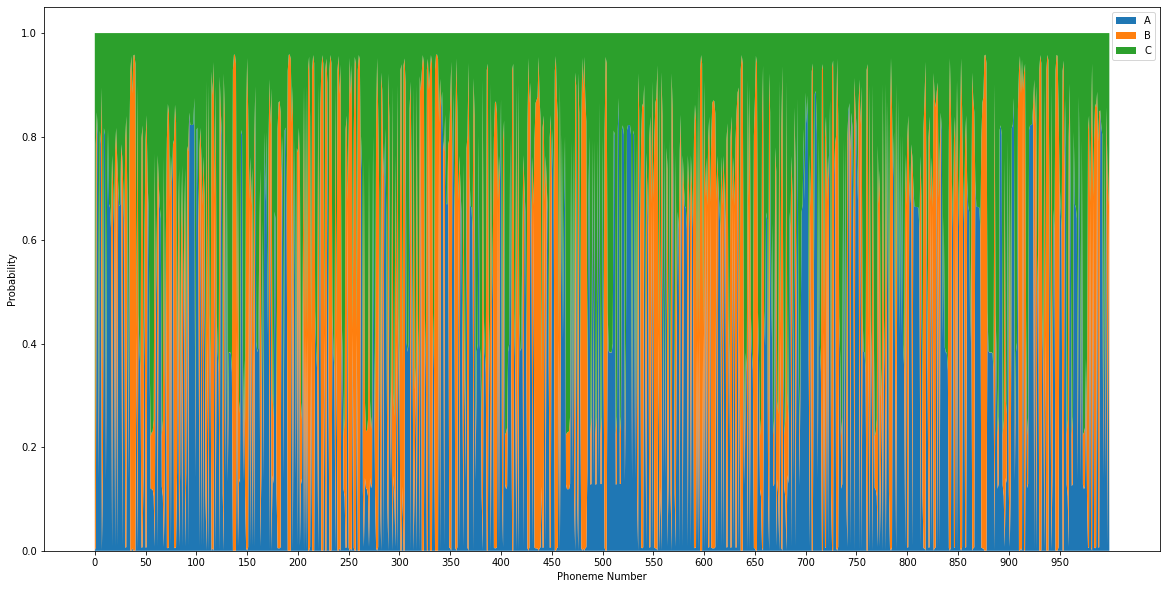

In [11]:
plt.figure(figsize = (20,10))
plt.stackplot(np.arange(len(speaker)), prob.values(), labels = prob.keys())
plt.xticks(np.arange(0,len(speaker), 50))
plt.legend()
plt.xlabel("Phoneme Number")
plt.ylabel("Probability")
plt.show()

The stackplot above shows the probability of each speaker saying a given phoneme. The dominance of a single colour over a vertical line shows that it has a high probability. The probabilities appear quite volatile where the rate of interrupting is fairly high. With different initialisation of the prior, we could arrive at a different equilibrium, but here we have chosen to randomly initialise.